In [1]:
# Import all the necessary packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# comment these out after testing
import sys
sys.path.append('..')
sys.path.append('../ark')

from ark.utils import spatial_analysis_utils, io_utils  # noqa: E402
from ark.analysis import spatial_analysis, visualize

# Read data

In [2]:
# Set up file paths and import data
base_dir = "../data/example_dataset/"
spatial_analysis_dir = os.path.join(base_dir, "spatial_enrichment_input_data")

In [3]:
# validate file paths (add other directories as needed)
io_utils.validate_paths([
    base_dir,
    spatial_analysis_dir,
])

In [4]:
# Import the necessary data
# This is the cell expression matrix including data for fovs 6 and 7, their cell labels, marker expression,
# cell phenotypes, and cell phenotype IDs.
all_data = pd.read_csv(os.path.join(spatial_analysis_dir, "example_expression_matrix.csv"))

In [5]:
# This is the Xarray of label maps for multiple fovs from which the distance matrix will be computed
label_maps = xr.load_dataarray(os.path.join(spatial_analysis_dir, "segmentation_labels.xr"))

# Get dictionary object with the respective distance matrices for the fovs
dist_mats = spatial_analysis_utils.calc_dist_matrix(label_maps)

# Compute neighborhood analysis

In [6]:
# Now with the same inputs, we will run a neighborhood analysis to determine counts for clusters of cells of different phenotypes. 
neighbor_counts, neighbor_freqs = spatial_analysis.create_neighborhood_matrix(all_data, dist_mats, distlim=50)

# Find optimal k for k-means clustering

In [7]:
# can use neighbor_freqs as well, default max_k chosen will be 10, metric computed is silhouette score
neighbor_silhouette_scores = spatial_analysis.compute_cluster_metrics(neighbor_counts)

Use the elbow curve method to choose the optimal k

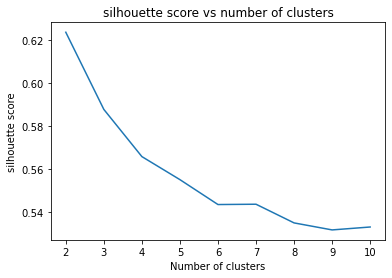

In [8]:
visualize.visualize_neighbor_cluster_metrics(neighbor_silhouette_scores)

# Generate cluster results

In [9]:
# set k value here based on results from graph above
k = 6

In [10]:
# need to drop the label col prior to clustering
neighbor_counts = neighbor_counts.drop(columns='cellLabelInImage')

In [11]:
# Columns, other than the marker columns, in the expression data
# These columns will be excluded from the analysis, so that a matrix of only markers can be extracted
excluded_colnames = ["SampleID", "cellLabelInImage", "cellSize", "C", "Na", "Si", "Background", "HH3",
                     "Ta", "Au", "Tissue", "PatientID", "lineage", "cell_type",
                     "cell_lin", "lintype_num", "FlowSOM_ID"]

In [12]:
num_cell_type_per_cluster, mean_marker_exp_per_cluster = \
    spatial_analysis.generate_cluster_matrix_results(
        all_data, neighbor_counts, cluster_num=k, excluded_colnames=excluded_colnames)

In [13]:
num_cell_type_per_cluster

cell_type,B_cell,CD11b/c_CD206_Mac/Mono,CD11c_DC/Mono,CD14_Mono,CD163_Mac,CD16_CD14_Mono,CD206_Mac,CD4_T,CD68_Mac,CD8_T,Treg,endothelial,epithelial,fibroblast,gdT_cell,giant_cell,imm_other,mast,neutrophil
cluster_labels,,,,,,,,,,,,,,,,,,,
0,14,1,1,19,0,4,1,64,0,54,0,28,0,2,0,0,131,1,0
1,39,14,39,199,2,90,5,151,44,124,0,83,0,8,1,4,120,3,7
2,0,228,8,0,0,11,0,17,4,5,0,1,0,0,0,0,0,0,1
3,19,5,5,41,0,27,7,272,9,122,0,25,1,0,1,0,108,2,0
4,11,13,12,35,0,43,0,301,15,82,1,47,0,7,2,0,21,0,5
5,5,162,36,14,0,93,5,69,44,55,0,4,0,5,0,0,1,1,1


In [14]:
mean_marker_exp_per_cluster

,Vimentin,SMA,Collagen.1,Lag3,CD4,CD14,Foxp3,PD.1,CD31,PD.L1,...,HLA.DR.DQ.DP,CD11b,CD45,H3K9Ac,Keratin.pan,CD103,MastChyTry,MPO,NaKATPase,HLA.Class.1
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0,0.444964,0.008209,0.359388,0,0.144673,0.087378,0.000000,0,0.080652,0.012414,...,0.344859,0.035228,0.492620,0.643771,0.000000,0.010088,0.003271,0.002803,0.248362,0.556511
1,0.560219,0.007655,0.326282,0,0.188801,0.278759,0.000591,0,0.068883,0.052008,...,0.445003,0.083630,0.521665,0.605271,0.000694,0.008194,0.003700,0.007474,0.375774,0.607655
2,0.736602,0.000811,0.058795,0,0.348873,0.569555,0.000000,0,0.002460,0.535261,...,0.673078,0.560935,0.697802,0.526731,0.000000,0.007519,0.000000,0.007340,0.693472,0.718568
3,0.560902,0.002186,0.346911,0,0.269723,0.186031,0.000000,0,0.035424,0.035258,...,0.405773,0.081121,0.589149,0.695633,0.003109,0.039958,0.004935,0.000000,0.387680,0.620926
4,0.649386,0.011351,0.283608,0,0.439247,0.383651,0.002506,0,0.076911,0.064909,...,0.519670,0.131737,0.687860,0.737039,0.006376,0.055646,0.001124,0.011058,0.568929,0.692072
5,0.731610,0.007233,0.187448,0,0.302887,0.550238,0.001673,0,0.011717,0.256782,...,0.606658,0.319931,0.669357,0.604231,0.000640,0.026087,0.002690,0.001128,0.640078,0.707653


# Overlay segmentation with neighborhood clusters

TODO: add visualization to do this

# Append cluster info to dataset